In [1]:
import os
from os.path import join, exists, basename, dirname, expanduser
from glob import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import rioxarray as rxa
from scipy import stats
from pyproj import Transformer

with open(expanduser('~/scratch/data/uavsar/image_fps'), 'rb') as f:
    image_fps = pickle.load(f)

image_fps = [f for f in image_fps if f['fp'].endswith('.unw.grd.tiff')]
netcdf_fps = '/bsuhome/zacharykeskinen/scratch/data/uavsar/images/vv_coherence'

data_fp = '/bsuhome/zacharykeskinen/scratch/data/uavsar/coherence'
with open(join(data_fp,'cor_vv.pkl'), 'rb') as f:
    cor_vv = pickle.load(f)

In [2]:
def clean_nps(arrs):
    idx = np.zeros_like(arrs[0], dtype = arrs[0].dtype)
    for arr in arrs:
        idx += arr

    for i in range(len(arrs)):
        arrs[i] = arrs[i][np.where(~np.isnan(idx))]
    return arrs

def clean_two_nps(arr1, arr2):
    buff = arr1
    arr1 = arr1[(~np.isnan(arr1)) & (~np.isnan(arr2))]
    arr2 = arr2[(~np.isnan(buff)) & (~np.isnan(arr2))]
    return arr1, arr2

def datarray_to_numpy(x, y):
    if type(x)== xr.core.dataarray.DataArray:
        x_dirty = x.values.ravel()
        y = y.values.ravel()
    else:
        x_dirty = x
    x = x_dirty[(~np.isnan(x_dirty)) & (~np.isnan(y))]
    y = y[(~np.isnan(x_dirty)) & (~np.isnan(y))]
    return x, y

def r2_value(x, y):
    x, y = datarray_to_numpy(x,y)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    print(f'slope: {slope}. intercept: {intercept}. r_value {r_value}. p value: {p_value}')
    return slope, intercept, r_value, p_value, x, y

def mann_test(x, y, xlabel = 'x', ylabel = 'y'):
    x, y = datarray_to_numpy(x,y)
    stat, p = mannwhitneyu(x, y)   
    print(f'Comparison of {xlabel} vs {ylabel} center has a p value of {p:.10f} of not being from same distribution with {len(x)} observations.')
    if p < 0.1:
        print(f'Median of {xlabel}: {np.median(x)} compared to median of {ylabel}: {np.median(y)}')

# Tree Height

In [3]:
treefp = '/bsuhome/zacharykeskinen/scratch/data/uavsar/trees/Forest_height_2019_NAM.tif'
treefull = rxa.open_rasterio(treefp)

In [4]:
for loc, ds in cor_vv.items():
    if 'tree-height' not in cor_vv[loc].data_vars:
        treeclip = treefull.rio.clip_box(*ds.rio.bounds())
        cor_vv[loc]['tree-height'] = treeclip.rio.reproject_match(cor_vv[loc])[0]

In [137]:
trees = []
cors = []
for loc, ds in cor_vv.items():
    for band in ds.band.values:
        ts = ds['tree-height']
        cor = ds.sel({'band':band})
        if cor.band.values.size > 1:
            cor = cor.isel({'band':0})
        insclean, csclean = clean_two_nps(ts.values.ravel(), cor['cor_vv'].values.ravel())
        trees.append(insclean)
        cors.append(csclean)
trees = np.concatenate(trees)
cors = np.concatenate(cors)
cors = cors[trees != 0]
trees = trees[(trees != 0)]

In [138]:
slope, intercept,r,p, _, _ = r2_value(trees, cors)

slope: -0.0022128898564640186. intercept: 0.5506681180466394. r_value -0.09204349607925778. p value: 0.0


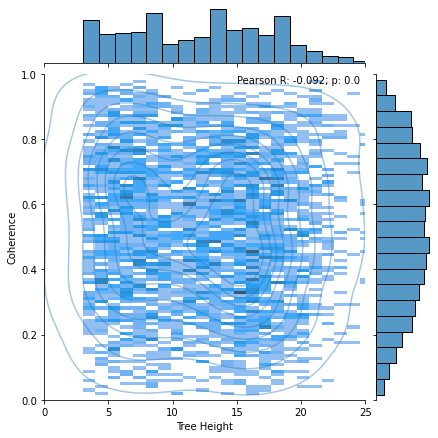

In [8]:
plt.Figure(figsize = (12,8))
g = sns.jointplot(x = trees[::50000], y = cors[::50000], kind = 'hist', bins = 100, ylim = (0,1), xlim = (0,25))
# g.plot_joint(sns.scatterplot, color="C0", zorder=1, alpha = 0.1)
g.plot_joint(sns.kdeplot, color="C0", zorder=1, alpha = 0.4)
xs = np.linspace(1, 20, 200)
ys = slope * xs + intercept
# sns.lineplot(x = np.rad2deg(xs),y = ys, zorder = 2, color = 'C1', ax = g.ax_joint)
g.ax_joint.annotate(text = f'Pearson R: {r:.2}; p: {p:.2}', xy = [15,0.97])
g.ax_joint.set_xlabel('Tree Height')
g.ax_joint.set_ylabel('Coherence')
plt.savefig(join('/bsuhome/zacharykeskinen/uavsar/figures/coherence_spatial/trees', 'all-tree-height-coh.png'))

# Tree Percentage

In [35]:
treefp = '/bsuhome/zacharykeskinen/scratch/data/uavsar/trees/nlcd/nlcd_2016_treecanopy_2019_08_31.img'
treefull = rxa.open_rasterio(treefp)

In [49]:
transformer = Transformer.from_crs("epsg:4326", "epsg:5070")
for loc, ds in cor_vv.items():
    if 'tree-perc' not in cor_vv[loc].data_vars:
        left, bottom = transformer.transform(*ds.rio.bounds()[:2][::-1])
        right, top = transformer.transform(*ds.rio.bounds()[2:][::-1])
        treeclip = treefull.rio.clip_box(left, bottom, right, top)
        treere = treeclip.rio.reproject_match(cor_vv[loc])[0]
        cor_vv[loc]['tree-perc'] = treere.where(treere != 255)

In [51]:
trees = []
cors = []
for loc, ds in cor_vv.items():
    for band in ds.band.values:
        ts = ds['tree-perc']
        cor = ds.sel({'band':band})
        if cor.band.values.size > 1:
            cor = cor.isel({'band':0})
        insclean, csclean = clean_two_nps(ts.values.ravel(), cor['cor_vv'].values.ravel())
        trees.append(insclean)
        cors.append(csclean)
trees = np.concatenate(trees)
cors = np.concatenate(cors)

In [52]:
slope, intercept,r,p, _, _ = r2_value(trees, cors)

slope: -0.0012208193446801752. intercept: 0.5689286699639985. r_value -0.11904959610507074. p value: 0.0


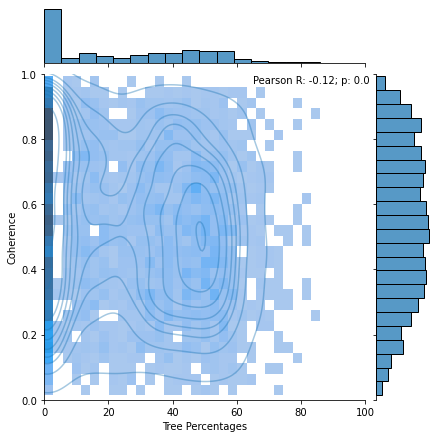

In [14]:
plt.Figure(figsize = (12,8))
g = sns.jointplot(x = trees[::50000], y = cors[::50000], kind = 'hist', bins = 30, ylim = (0,1), xlim = (0,100))
# g.plot_joint(sns.scatterplot, color="C0", zorder=1, alpha = 0.1)
g.plot_joint(sns.kdeplot, color="C0", zorder=1, alpha = 0.4)
g.ax_joint.annotate(text = f'Pearson R: {r:.2}; p: {p:.2}', xy = [65,0.97])
g.ax_joint.set_xlabel('Tree Percentages')
g.ax_joint.set_ylabel('Coherence')
plt.savefig(join('/bsuhome/zacharykeskinen/uavsar/figures/coherence_spatial/trees', 'all-tree-perc-coh.png'))

# Biomass

In [105]:
treefp = '/bsuhome/zacharykeskinen/scratch/data/uavsar/trees/biomass/conus_forest_biomass_mg_per_ha.img'
treefull = rxa.open_rasterio(treefp)
treefull = treefull.rio.set_crs('EPSG:5070')

In [106]:
transformer = Transformer.from_crs("epsg:4326", "epsg:5069")
for loc, ds in cor_vv.items():
    if 'biomass' not in cor_vv[loc].data_vars:
        left, bottom = transformer.transform(*ds.rio.bounds()[:2][::-1])
        right, top = transformer.transform(*ds.rio.bounds()[2:][::-1])
        treeclip = treefull.rio.clip_box(left, bottom, right, top)
        treere = treeclip.rio.reproject_match(cor_vv[loc])[0]
        cor_vv[loc]['biomass'] = treere.where(treere < 1000)

In [248]:
trees = []
cors = []
for loc, ds in cor_vv.items():
    for band in ds.band.values:
        ts = ds['biomass']
        cor = ds.sel({'band':band})
        if cor.band.values.size > 1:
            cor = cor.isel({'band':0})
        insclean, csclean = clean_two_nps(ts.values.ravel(), cor['cor_vv'].values.ravel())
        trees.append(insclean)
        cors.append(csclean)
trees = np.concatenate(trees)
cors = np.concatenate(cors)
cors = cors[trees < 10000]
trees = trees[(trees < 10000)]
cors = cors[trees > 0]
trees = trees[(trees > 0)]

In [249]:
slope, intercept,r,p, _, _ = r2_value(trees, cors)

slope: 0.0004632661335106672. intercept: 0.47510642487950755. r_value 0.10953317855571625. p value: 0.0


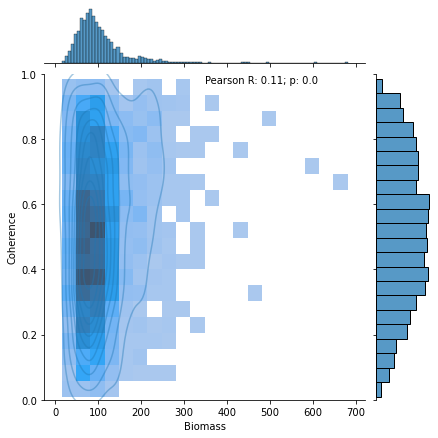

: 

In [250]:
plt.Figure(figsize = (12,8))
g = sns.jointplot(x = trees[::50000], y = cors[::50000], kind = 'hist', bins = 20, ylim = (0,1))
# g.plot_joint(sns.scatterplot, color="C0", zorder=1, alpha = 0.1)
g.plot_joint(sns.kdeplot, color="C0", zorder=1, alpha = 0.4)
g.ax_joint.annotate(text = f'Pearson R: {r:.2}; p: {p:.2}', xy = [350,0.97])
g.ax_joint.set_xlabel('Biomass')
g.ax_joint.set_ylabel('Coherence')
plt.savefig(join('/bsuhome/zacharykeskinen/uavsar/figures/coherence_spatial/trees', 'all-biomass-coh.png'))

# Inc control

In [115]:
trees = []
cors = []
incs = []
for loc, ds in cor_vv.items():
    for band in ds.band.values:
        direction = band.split('_')[1][:3]
        inc_name = f'{direction}-inc'
        inc = ds[inc_name]
        ts = ds['biomass']
        cor = ds.sel({'band':band})
        if cor.band.values.size > 1:
            cor = cor.isel({'band':0})
        insclean, csclean, incclean = clean_nps([ts.values.ravel(), cor['cor_vv'].values.ravel(), inc.values.ravel()])
        trees.append(insclean)
        cors.append(csclean)
        incs.append(incclean)
trees = np.concatenate(trees)
cors = np.concatenate(cors)
incs = np.concatenate(incs)
cors = cors[trees < 1000]
incs = incs[trees < 1000]
trees = trees[(trees < 1000)]
# cors = cors[trees > 0]
# incs = incs[trees > 0]
# trees = trees[(trees > 0)]
incs = np.rad2deg(incs)

In [117]:
slope, intercept,r,p, _, _ = r2_value(trees[(incs < 60) & (incs > 40)], cors[(incs < 60) & (incs > 40)])

slope: -0.0003030012911409673. intercept: 0.5926003975721506. r_value -0.0850641794221615. p value: 0.0


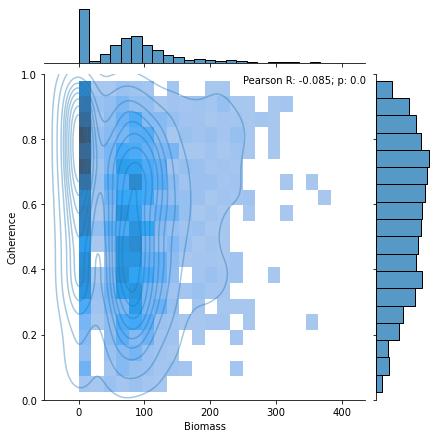

In [118]:
med_inc = (incs < 65) & (incs > 40)
g = sns.jointplot(x = trees[med_inc][::50000], y = cors[med_inc][::50000], kind = 'hist', bins = 20, ylim = (0,1))
# g.plot_joint(sns.scatterplot, color="C0", zorder=1, alpha = 0.1)
g.plot_joint(sns.kdeplot, color="C0", zorder=1, alpha = 0.4)
g.ax_joint.annotate(text = f'Pearson R: {r:.2}; p: {p:.2}', xy = [250,0.97])
g.ax_joint.set_xlabel('Biomass')
g.ax_joint.set_ylabel('Coherence')
plt.savefig(join('/bsuhome/zacharykeskinen/uavsar/figures/coherence_spatial/trees', 'all-biomass-inc-coh.png'))

# inc control percentage

In [23]:
trees = []
cors = []
incs = []
for loc, ds in cor_vv.items():
    for band in ds.band.values:
        direction = band.split('_')[1][:3]
        inc_name = f'{direction}-inc'
        inc = ds[inc_name]
        ts = ds['tree-perc']
        cor = ds.sel({'band':band})
        if cor.band.values.size > 1:
            cor = cor.isel({'band':0})
        insclean, csclean, incclean = clean_nps([ts.values.ravel().astype(float), cor['cor_vv'].values.ravel(), inc.values.ravel()])
        trees.append(insclean)
        cors.append(csclean)
        incs.append(incclean)
trees = np.concatenate(trees)
cors = np.concatenate(cors)
incs = np.concatenate(incs)
cors = cors[trees < 101]
incs = incs[trees < 101]
trees = trees[(trees < 101)]
incs = np.rad2deg(incs)

In [24]:
med_inc = (incs < 60) & (incs > 40)
slope, intercept,r,p, _, _ = r2_value(trees[med_inc], cors[med_inc])

slope: -0.0019906411086118305. intercept: 0.619409230570193. r_value -0.20089563117082698. p value: 0.0


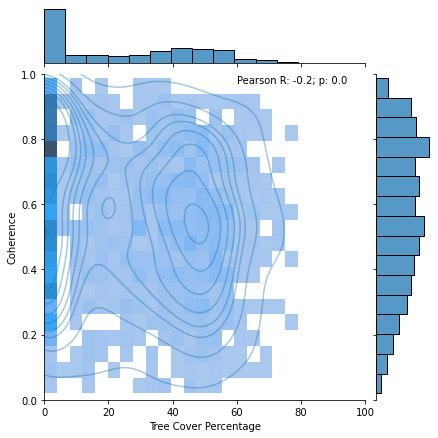

In [25]:
med_inc = (incs < 60) & (incs > 40)

plt.Figure(figsize = (12,8))
g = sns.jointplot(x = trees[med_inc][::50000], y = cors[med_inc][::50000], kind = 'hist', bins = 20, ylim = (0,1), xlim = (0,100))
# g.plot_joint(sns.scatterplot, color="C0", zorder=1, alpha = 0.1)
g.plot_joint(sns.kdeplot, color="C0", zorder=1, alpha = 0.4)
g.ax_joint.annotate(text = f'Pearson R: {r:.2}; p: {p:.2}', xy = [60,0.97])
g.ax_joint.set_xlabel('Tree Cover Percentage')
g.ax_joint.set_ylabel('Coherence')
plt.savefig(join('/bsuhome/zacharykeskinen/uavsar/figures/coherence_spatial/trees', 'all-perc-inc-coh.png'))

## control for inc and time

In [148]:
trees = []
cors = []
incs = []
for loc, ds in cor_vv.items():
    for band in ds.band.values:
        days = int(band.split('_')[-1].replace('d',''))
        if days < 8:
            direction = band.split('_')[1][:3]
            inc_name = f'{direction}-inc'
            inc = ds[inc_name]
            ts = ds['tree-perc']
            cor = ds.sel({'band':band})
            if cor.band.values.size > 1:
                cor = cor.isel({'band':0})
            insclean, csclean, incclean = clean_nps([ts.values.ravel().astype(float), cor['cor_vv'].values.ravel(), inc.values.ravel()])
            trees.append(insclean)
            cors.append(csclean)
            incs.append(incclean)
trees = np.concatenate(trees)
cors = np.concatenate(cors)
incs = np.concatenate(incs)
cors = cors[trees < 101]
incs = incs[trees < 101]
trees = trees[(trees < 101)]
incs = np.rad2deg(incs)

In [129]:
med_inc = (incs < 60) & (incs > 40)
slope, intercept,r,p, _, _ = r2_value(trees[med_inc], cors[med_inc])

slope: -0.0022752148048306295. intercept: 0.6443377614265158. r_value -0.2288666814933243. p value: 0.0


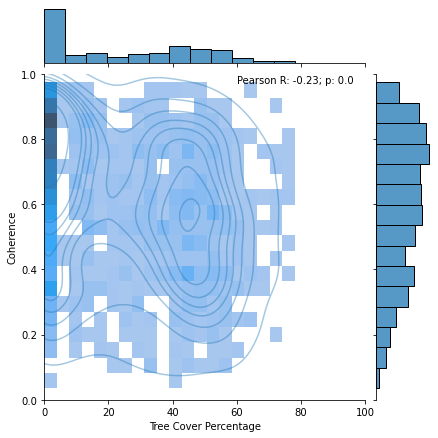

In [130]:
med_inc = (incs < 60) & (incs > 40)

plt.Figure(figsize = (12,8))
g = sns.jointplot(x = trees[med_inc][::50000], y = cors[med_inc][::50000], kind = 'hist', bins = 20, ylim = (0,1), xlim = (0,100))
# g.plot_joint(sns.scatterplot, color="C0", zorder=1, alpha = 0.1)
g.plot_joint(sns.kdeplot, color="C0", zorder=1, alpha = 0.4)
g.ax_joint.annotate(text = f'Pearson R: {r:.2}; p: {p:.2}', xy = [60,0.97])
g.ax_joint.set_xlabel('Tree Cover Percentage')
g.ax_joint.set_ylabel('Coherence')
plt.savefig(join('/bsuhome/zacharykeskinen/uavsar/figures/coherence_spatial/trees', 'all-perc-inc-time-coh.png'))

## Incidence Angle Controlled for Trees and Time

In [151]:
treeless = trees < 5
slope, intercept,r,p, _, _ = r2_value(incs[treeless], cors[treeless])

slope: -0.004456668873886222. intercept: 0.8381547347696516. r_value -0.34005938784078776. p value: 0.0


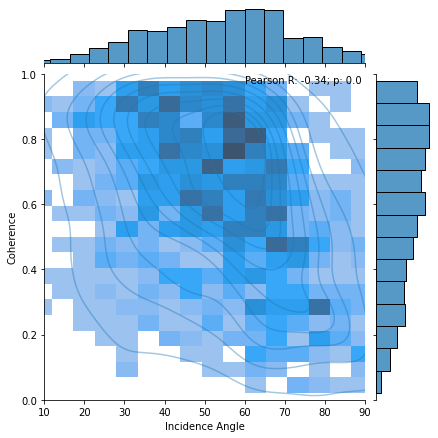

In [157]:
treeless = trees < 5

plt.Figure(figsize = (12,8))
g = sns.jointplot(x = incs[treeless][::50000], y = cors[treeless][::50000], kind = 'hist', bins = 20, ylim = (0,1), xlim = (10,90))
# g.plot_joint(sns.scatterplot, color="C0", zorder=1, alpha = 0.1)
g.plot_joint(sns.kdeplot, color="C0", zorder=1, alpha = 0.4)
g.ax_joint.annotate(text = f'Pearson R: {r:.2}; p: {p:.2}', xy = [60,0.97])
g.ax_joint.set_xlabel('Incidence Angle')
g.ax_joint.set_ylabel('Coherence')
plt.savefig(join('/bsuhome/zacharykeskinen/uavsar/figures/coherence_spatial/incidence-angle', 'inc-time-tree-cor.png'))

0.22112364083595287
0.4035603809215485


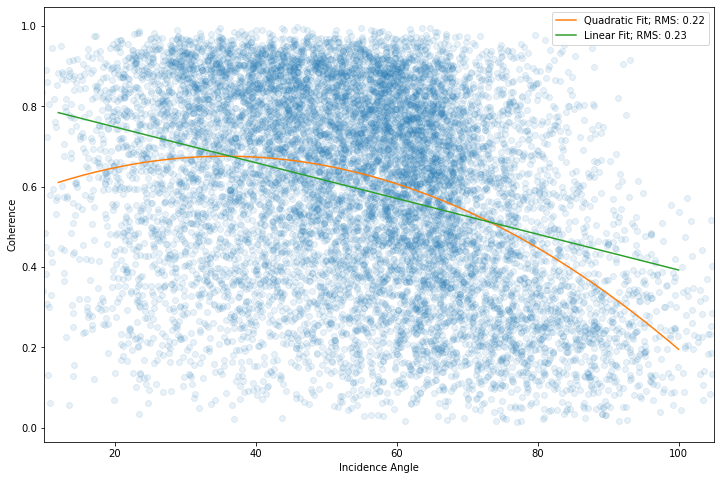

In [247]:
fit = np.polyfit(incs[treeless], cors[treeless], 2)
y_predicted = np.polyval(fit, incs[treeless])
from sklearn import metrics
rms = metrics.mean_squared_error(cors[treeless][::1000], y_predicted[::1000])**(0.5)
print(rms)
r = np.corrcoef(cors[treeless][::1000], y_predicted[::1000])[0,1]
print(r)

plt.subplots(figsize = (12,8))
xs = np.linspace(12,100, 200)
ys = np.polyval(fit, xs)
plt.plot(xs, ys, label = f'Quadratic Fit; RMS: {rms:.2}', color = 'C1')

fit = np.polyfit(incs[treeless], cors[treeless], 1)
ys = np.polyval(fit, xs)
y_predicted = np.polyval(fit, incs[treeless])
rms = metrics.mean_squared_error(cors[treeless][::1000], y_predicted[::1000])**(0.5)
plt.plot(xs, ys, label = f'Linear Fit; RMS: {rms:.2}', color = 'C2')

plt.scatter(incs[treeless][::5000], cors[treeless][::5000], alpha = 0.1)
plt.xlabel('Incidence Angle')
plt.ylabel('Coherence')
# plt.annotate(xy = (80, 0.9), text = f'Pearson R: {r:.2}; RMS: {rms:.2}')
plt.xlim(10, 105)
plt.legend()
plt.savefig('/bsuhome/zacharykeskinen/uavsar/figures/coherence_spatial/incidence-angle/polyfit.png')